In [1]:
from qiskit import QuantumCircuit
from qiskit.providers.basic_provider import BasicSimulator
from qiskit.visualization import plot_histogram, plot_bloch_vector
from qiskit.primitives import BackendSampler
from qiskit.quantum_info import SparsePauliOp, Statevector
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from numpy import pi
import numpy as np
import matplotlib.pyplot as plt

## Introduction to Qubits

Quantum bits, more commonly referred to as Qubits, are particles used as "bits" in Quantum computation. Qubits function quite differently than classical bits because of the phenomenon of superposition. This difference requires a new computational approach to circuits.

Similar to classical bits, qubits have two distinct states that a Quantum Computer can read, "spin up" and "spin down". We represent these states as $|0\rangle$ and $|1\rangle$ respectively where the $|\rangle$ around each state is called a "ket". This notation method is called Dirac notation or bra-ket notation and is most commonly how quantum states are represented.

The $|0\rangle$ and $|1\rangle$ states represent an orthonormal basis. This means that each of the states has a unit length of one and orthogonal to each other.

Another way to represent the spin states is with vectors. For example, the $|0\rangle$ and $|1\rangle$ could be written as: 

$$|0\rangle =  \begin{pmatrix}1\\0\end{pmatrix}$$

$$|1\rangle =  \begin{pmatrix}0\\1\end{pmatrix}$$

### Superposition
Superposition is a phenonum where a <b>single</b> object can be in combination of <b>multiple</b> states at the same time. An example of a superposition state is the $|+\rangle$ state which is a superposition of $|0\rangle$ and $|1\rangle$.

$$|+\rangle = \frac{1}{\sqrt{2}}(|0\rangle + |1\rangle) = \frac{1}{\sqrt{2}} \begin{pmatrix}1\\1\end{pmatrix}$$

Superposition allows qubits to preform much more complex calculations in far fewer steps that their classical counterparts. In theory, this allows Quantum Computers to be able to construct and perform algorthims that are much faster than classical computing methods.

### Bloch Sphere
A common technique for visualizing superposition states is the Bloch sphere. The Z-axis represents the probability of measuring $|0\rangle$ or $|1\rangle$. The X-axis represents the real component of that probability, and the Y-axis represents the imaginary component of that probability.

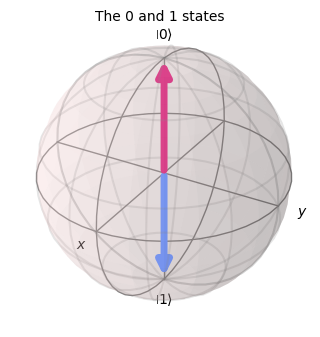

In [2]:
plot_bloch_vector(([0,0,1],[0,0,-1]), title='The 0 and 1 states', figsize=(3,3))

$$\text{Fig. }1:\text{ Bloch sphere denoting the states }|0\rangle \text{ (pink) and }|1\rangle\text{ (blue)}$$

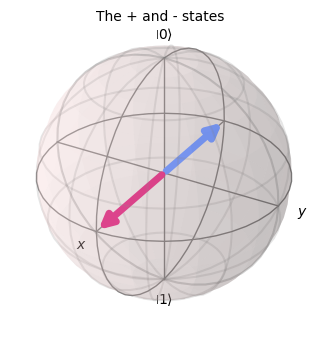

In [3]:
plot_bloch_vector(([1,0,0],[-1,0,0]), title='The + and - states', figsize=(3,3))

$$\text{Fig. }2:\text{ Bloch sphere denoting the states }|+\rangle \text{ (pink) and }|-\rangle\text{ (blue)}$$

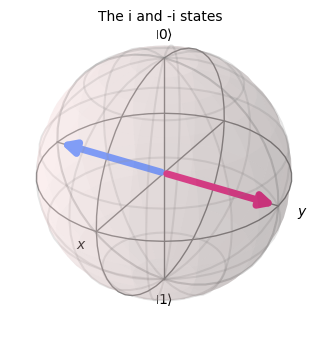

In [4]:
plot_bloch_vector(([0,1,0],[0,-1,0]), title='The i and -i states', figsize=(3,3))

$$\text{Fig. }3:\text{ Bloch sphere denoting the states }|i\rangle \text{ (pink) and }|-i\rangle\text{ (blue)}$$

### Measurement
The principle of superposition creates an ambiguity about what will happen when we want to measure it. When measuring a qubit in superposition, it collapses in to one of the states that its state it is in a combination of. For example if we were to take the $|+\rangle$ state try to measure it sometimes we would get $0$ and other times we would get $1$, each with their own probabilites. To calculate these probabilities we first need to find the coeffiecent in front of the state we want to measure. To find this coeffecient we can do an inner product or a dot product of the Hermitian of the desired state with the current state of the particle. (For those with a background in Linear Algebra, a Hermitian is equivent to a conjugate transpose.) Notationally in Quantum Computing, a Hermitian is marked using $\dagger$ ("dagger"). The Hermitian of a generic state can also be written in Dirac notation as $\langle \psi|$ where $\langle |$ is pronouced as "bra".

Suppose we wanted to see what fraction of the time we will measure $|0\rangle$ from the $|+\rangle$ state. Since $|0\rangle$ and $|1\rangle$ are normal, the inner products of either of the two of the same states will be $1$. In addition to being normal, $|0\rangle$ and $|1\rangle$ are also orthogonal so the inner product of two different states will be $0$. By performing the same calculation in Dirac notation and alternatively with linear algebra, we can see how they are equivalent processes and we end up with the same result.

Linear Algebra:
$$\langle 0|+\rangle = \begin{pmatrix}1\\0\end{pmatrix}^\dagger\frac{1}{\sqrt{2}}\begin{pmatrix}1\\1\end{pmatrix} = \begin{pmatrix}1&0\end{pmatrix}\frac{1}{\sqrt{2}}\begin{pmatrix}1\\1\end{pmatrix} = \frac{1}{\sqrt{2}}(1 + 0) = \frac{1}{\sqrt{2}}$$

Dirac notation:
$$\langle 0|+\rangle = \langle 0|\left(\frac{1}{\sqrt{2}}(|0\rangle + |1\rangle)\right) = \frac{1}{\sqrt{2}}(\langle 0|0\rangle + \langle 0|1\rangle) = \frac{1}{\sqrt{2}} (1 + 0) = \frac{1}{\sqrt{2}}$$

Because coefficients of quantum states can be partial imaginary, there is a possibility the calculated coeffienct is a complex number, which doesn't make physical sense for a probability. To this end we multiply the coefficient by its complex conjugate to find the true probability.

$$\mathbb{P}(|0\rangle) = |\langle 0|+\rangle|^2 = \langle 0|+ \rangle (\langle 0|+\rangle)^\dagger = \langle 0|+ \rangle \langle +|0\rangle =  \frac{1}{\sqrt{2}}\cdot\frac{1}{\sqrt{2}} = \frac{1}{2}$$

This means that $50\%$ of the time we will measure $|0\rangle$ from $|+\rangle$. <b>For any state $|\psi\rangle$ the sum of the probability of the states of basis must be equal to 1</b>. This follow from the fact that putting a particle into superposition doesn't create or destroy parts of the particle. 

In order to find a probability of a particle being in a state, this always requires we multiply it by its complex conjugate. Therefore, there can be states that are equivalent to each other with different constants. For example, $e^{\pi/4}|0\rangle \equiv |0\rangle$ in the $Z$-Basis. This means that $e^{\pi/4}|0\rangle$ and $|0\rangle$ have a different global phase, but when measuring them there will be no distinction. <b>Global Phase doesn't affect the probabilities of measurement.</b>

## Single Qubit Gates
Before performing calculations with qubits, the qubits must be setup in the correct states. The following single qubit gates are common ways to adjust the states of individual qubits.

### X-gate
The $X$-gate is a bit flip, which is a $180^{\circ}$ rotation around the $x$-axis on the Bloch sphere.
$$X = \begin{pmatrix}0&1\\1&0\end{pmatrix}$$
$$X|0\rangle = \begin{pmatrix}0&1\\1&0\end{pmatrix}\begin{pmatrix}1\\0\end{pmatrix} = \begin{pmatrix}0\\1\end{pmatrix} = |1\rangle$$
$$X|1\rangle = \begin{pmatrix}0&1\\1&0\end{pmatrix}\begin{pmatrix}0\\1\end{pmatrix} = \begin{pmatrix}1\\0\end{pmatrix} = |0\rangle$$
The $X$-Basis is $|+\rangle$ and $|-\rangle$

### Z-gate
The $Z$-gate is a phase-flip, which is a $180^{\circ}$ rotation around the $z$-axis on the Bloch sphere.
$$Z = \begin{pmatrix}1&0\\0&-1\end{pmatrix}$$
$$Z|0\rangle = \begin{pmatrix}1&0\\0&-1\end{pmatrix}\begin{pmatrix}1\\0\end{pmatrix} = \begin{pmatrix}1\\0\end{pmatrix} = |0\rangle$$
$$Z|1\rangle = \begin{pmatrix}1&0\\0&-1\end{pmatrix}\begin{pmatrix}0\\1\end{pmatrix} = \begin{pmatrix}0\\-1\end{pmatrix} = -|1\rangle$$
The $Z$-Basis is $|0\rangle$ and $|1\rangle$

### Y-gate
The $Y$-gate is a phase-flip and a bit flip, which is a $180^{\circ}$ rotation around the $y$-axis on the Bloch sphere.
$$Y = \begin{pmatrix}0&-i\\i&0\end{pmatrix}$$
$$Y|0\rangle = \begin{pmatrix}0&-i\\i&0\end{pmatrix}\begin{pmatrix}1\\0\end{pmatrix} = \begin{pmatrix}0\\i\end{pmatrix} = i|1\rangle$$
$$Y|1\rangle = \begin{pmatrix}0&-i\\i&0\end{pmatrix}\begin{pmatrix}0\\1\end{pmatrix} = \begin{pmatrix}-i\\0\end{pmatrix} = -i|0\rangle$$
The $Y$-Basis is $|i\rangle$ and $|-i\rangle$ explicitly denoted below.

$$|i\rangle = \frac{1}{\sqrt{2}}(|0\rangle + i|1\rangle) = \frac{1}{\sqrt{2}} \begin{pmatrix}1\\i\end{pmatrix}$$
$$|-i\rangle = \frac{1}{\sqrt{2}}(|0\rangle - i|1\rangle) = \frac{1}{\sqrt{2}} \begin{pmatrix}1\\-i\end{pmatrix}$$

### "I"-Gate
The Identity Gate does nothing to the state that is put into it. 
$$I = \begin{pmatrix}1&0\\0&1\end{pmatrix}$$
$$I|0\rangle = \begin{pmatrix}1&0\\0&1\end{pmatrix}\begin{pmatrix}1\\0\end{pmatrix} = \begin{pmatrix}1\\0\end{pmatrix} = |0\rangle$$
$$I|1\rangle = \begin{pmatrix}1&0\\0&1\end{pmatrix}\begin{pmatrix}0\\1\end{pmatrix} = \begin{pmatrix}0\\1\end{pmatrix} = |1\rangle$$

### H-Gate
The Hadamard Gate puts an individual qubit into superposition.

$$H=\frac{1}{\sqrt{2}}\begin{pmatrix} 1 & 1\\1 & -1\end{pmatrix}$$

$$H|0\rangle = \frac{1}{\sqrt{2}}\begin{pmatrix} 1 & 1\\1 & -1\end{pmatrix} \begin{pmatrix}1\\0\end{pmatrix} = \frac{1}{\sqrt{2}}\begin{pmatrix}1\\1\end{pmatrix} = \begin{pmatrix}\frac{1}{\sqrt{2}}\\\frac{1}{\sqrt{2}}\end{pmatrix}$$


$$H|1\rangle =  \frac{1}{\sqrt{2}}\begin{pmatrix} 1 & 1\\1 & -1\end{pmatrix} \begin{pmatrix}0\\1\end{pmatrix} = \frac{1}{\sqrt{2}}\begin{pmatrix}1\\-1\end{pmatrix} = \begin{pmatrix}\frac{1}{\sqrt{2}}\\-\frac{1}{\sqrt{2}}\end{pmatrix}$$

In Dirac notation, these states are represented as

$$H|0\rangle = \frac{1}{\sqrt{2}}\left(|0\rangle + |1\rangle\right) = |+\rangle$$
$$H|1\rangle = \frac{1}{\sqrt{2}}\left(|0\rangle - |1\rangle\right) = |-\rangle$$

## Control Gates
Control Gates are gates that change one qubit based off of the state of another. To determine what they will look like as matrices we must first discuss how to compute tensor products.
### Tensor Products
Tensor products are a way to linearly combine different objects to represent independent combinations of them. For example say we wanted to represent the state $|0\rangle|1\rangle$ as a vector.

$$ |0\rangle|1\rangle = \begin{pmatrix}1\\0\end{pmatrix} \otimes \begin{pmatrix}0\\1\end{pmatrix} = \begin{pmatrix}1 \begin{pmatrix}0\\1\end{pmatrix} \\0 \begin{pmatrix}0\\1\end{pmatrix} \end{pmatrix} = \begin{pmatrix}0\\1\\0\\0\end{pmatrix} $$

Or suppose we wanted to represent the circuit shown in $\text{Fig. }4$ as a matrix.

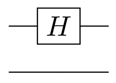

$$\text{Fig. }4:\text{ Tensor Product Example Circuit}$$

We can do this via a tensor product with the $H$ and $I$ matrices denoted as $H\otimes I$.
$$H \otimes I = \frac{1}{\sqrt{2}} \begin{pmatrix}1&1\\1&-1\end{pmatrix} \otimes \begin{pmatrix}1&0\\0&1\end{pmatrix} =
\frac{1}{\sqrt{2}} \begin{pmatrix}1 \begin{pmatrix}1&0\\0&1\end{pmatrix}&1 \begin{pmatrix}1&0\\0&1\end{pmatrix}\\1 \begin{pmatrix}1&0\\0&1\end{pmatrix}&-1 \begin{pmatrix}1&0\\0&1\end{pmatrix}\end{pmatrix} =  \begin{pmatrix}1&0&1&0\\0&1&0&1\\1&0&-1&0\\0&1&0&-1\end{pmatrix}$$

This matrix can be use to represent any pair of qubits that travels through it. 


### $CNOT$-Gate
One controlled gate is the $CNOT_{01}$ gate (can also be written as $CX_{01}$). The first number of the subscript is the control qubit's number and the second number is the target qubit's number. The convention for notating which qubit is the target qubit and which qubit is the control qubit is not currently standardized.
$$CNOT_{01}|00\rangle = \begin{pmatrix}1&0&0&0 \\ 0&1&0&0 \\ 0&0&0&1 \\ 0&0&1&0 \end{pmatrix}\begin{pmatrix}1\\0\\0\\0\end{pmatrix} = \begin{pmatrix}1\\0\\0\\0\end{pmatrix} = |00\rangle$$
$$CNOT_{01}|01\rangle = \begin{pmatrix}1&0&0&0 \\ 0&1&0&0 \\ 0&0&0&1 \\ 0&0&1&0 \end{pmatrix}\begin{pmatrix}0\\1\\0\\0\end{pmatrix} = \begin{pmatrix}0\\1\\0\\0\end{pmatrix} = |01\rangle$$
$$CNOT_{01}|10\rangle = \begin{pmatrix}1&0&0&0 \\ 0&1&0&0 \\ 0&0&0&1 \\ 0&0&1&0 \end{pmatrix}\begin{pmatrix}0\\0\\1\\0\end{pmatrix} = \begin{pmatrix}0\\0\\0\\1\end{pmatrix} = |11\rangle$$
$$CNOT_{01}|11\rangle = \begin{pmatrix}1&0&0&0 \\ 0&1&0&0 \\ 0&0&0&1 \\ 0&0&1&0 \end{pmatrix}\begin{pmatrix}0\\0\\0\\1\end{pmatrix} = \begin{pmatrix}0\\0\\1\\0\end{pmatrix} = |10\rangle$$

### Deriving a Matrix for an Arbitrary Gate

Suppose we knew of a gate such that:
$$U|00\rangle = |11\rangle$$
$$U|10\rangle = |01\rangle$$
$$U|01\rangle = |10\rangle$$
$$U|11\rangle = |00\rangle$$
To create a matrix for this operation, we can add the inner products of the hermitians all the input states times each of their own output.
$$U = |00\rangle \langle 11| + |01\rangle \langle 10| + |10\rangle \langle 01| + |10\rangle \langle 01| + |00\rangle \langle 11|$$
$$U = \begin{pmatrix}1\\0\\0\\0\end{pmatrix} \begin{pmatrix}0&0&0&1\end{pmatrix} + \begin{pmatrix}0\\1\\0\\0\end{pmatrix} \begin{pmatrix}0&0&1&0\end{pmatrix} + \begin{pmatrix}0\\0\\1\\0\end{pmatrix} \begin{pmatrix}0&1&0&0\end{pmatrix} + \begin{pmatrix}0\\0\\0\\1\end{pmatrix} \begin{pmatrix}1&0&0&0\end{pmatrix}$$
$$U = \begin{pmatrix}0&0&0&1\\0&0&0&0\\0&0&0&0\\0&0&0&0\end{pmatrix} + \begin{pmatrix}0&0&0&0\\0&0&1&0\\0&0&0&0\\0&0&0&0\end{pmatrix} + \begin{pmatrix}0&0&0&0\\0&0&0&0\\0&1&0&0\\0&0&0&0\end{pmatrix} + \begin{pmatrix}0&0&0&0\\0&0&0&0\\0&0&0&0\\1&0&0&0\end{pmatrix} = \begin{pmatrix}0&0&0&1\\0&0&1&0\\0&1&0&0\\1&0&0&0\end{pmatrix}$$

Then benefit of this notation is how clearly it maps input to output.

## Eigenvalues and Eigenvectors
Since every qubit gate can be represented as matrix and every state as a vector, understanding eigenvalues and eigenvectors is essential. Eigenvalues and eigenvectors are special scalars and vectors that solve the problem:

$U|\psi\rangle = \lambda|\psi\rangle$

where $\lambda$ represents an eigenvalue and $|\psi\rangle$ represents an eigenvector. Since not every arbitrary pair of Eigenvalues and Eigenvectors will solve this equation, it is important to track which Eigenvalues go with which Eigenvectors. Eigenvectors form a basis and unit length eigenvectors form an orthnormal basis.

Since at any point during a quantum operation the probablilty of the state must be exactly one, Eigenvalues of the state must be exactly 1 unit away from the origin on the complex plane. Eigenvalues that fit this condition follow the form $\lambda = e^{i\theta}$. ($e^{i\theta} = \cos\theta + i\sin\theta \implies |e^{i\theta}|^2 = (\cos\theta+i\sin\theta)(\cos\theta-i\sin\theta) = \cos^2\theta+\sin^2\theta = 1$)

Often Eigenvalues of gates are written as $\lambda = e^{i2\pi\varphi_k}$ where $0\leq \varphi_k \leq 1$, instead of using $\theta$. We can think of this $\varphi_k$ in the exponent "$i2\pi\varphi$" as the location of a point around the complex unit circle. The real number $\varphi$ is rotating this point form $i0 \text{ rad}$ to $i2\pi \text{ rad}$ as $\varphi$ goes from $0$ to $1$. Ensuring we are including $0$ and not $1$ for the range of $\varphi$ guarantees that we can represent every point on the complex unit circle with a unique value of $\varphi$ for every point. This is because $i0\text{ rad}$ and $i2\pi\text{ rad}$ are the same position on the complex unit circle.